In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.pyplot as plt
from PIL import Image

In [7]:
# Define image dimensions
img_width, img_height = 256, 256

# Define paths to training and validation data folders
train_dir = r'D:\ITI\Computer vision\Dataset_task_1\Train'
test_dir = r'D:\ITI\Computer vision\Dataset_task_1\Test'

In [8]:
# Define batch size
batch_size = 32

# Define image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 1346 images belonging to 2 classes.
Found 336 images belonging to 2 classes.
Found 299 images belonging to 2 classes.


In [9]:
# Define number of samples and epochs from the above output
nb_train_samples = 1364
nb_validation_samples = 336
nb_test_samples= 299
nb_brain_train= len(os.listdir(r'D:\ITI\Computer vision\Dataset_task_1\Train\0'))
nb_breast_train= len(os.listdir(r'D:\ITI\Computer vision\Dataset_task_1\Train\1'))

In [10]:
classes_weight= {0: nb_brain_train / nb_train_samples, 1: nb_breast_train / nb_train_samples}

In [11]:
def f1score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    precision = tp/(tp+fp+K.epsilon())
    recall = tp/(tp+fn+K.epsilon())
    f1 = 2*(precision*recall)/(precision+recall+K.epsilon())
    return K.mean(f1)


In [12]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# build a classifier model to put on top of the convolutional model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5), 
              metrics=[f1score])

In [13]:
# Train model
model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs= 2,
    class_weight=classes_weight,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/2
42/42 [==============================] - 35s 525ms/step - loss: 0.1037 - f1score: 0.7886 - val_loss: 4.4657e-04 - val_f1score: 1.0000
Epoch 2/2
42/42 [==============================] - 21s 498ms/step - loss: 0.0031 - f1score: 0.9737 - val_loss: 8.3659e-05 - val_f1score: 1.0000


In [14]:
# Evaluate the model
model.evaluate(test_generator)

10/10 [==============================] - 3s 320ms/step - loss: 8.8945e-05 - f1score: 1.0000


[8.894507482182235e-05, 1.0]

In [34]:
# Prediction function
def predict_image(model, img_path):
    # Define labels
    labels= ["Brain", "Breast"]
    # Load image and convert to array
    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction using the model
    prediction = model.predict(img_array)
    
    if prediction > 0.5:
        pred= labels[1]
    else:
        pred= labels[0]

    img= np.asarray(Image.open(img_path))
    plt.imshow(img)
    plt.title("Predicted: "+ pred)

    # Return predicted label (0 or 1)
    return pred

1/1 [==============================] - 0s 23ms/step


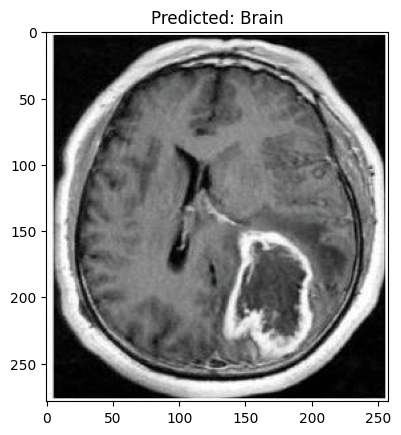

In [35]:
# Test case brain
random_img= np.random.choice(os.listdir(os.path.join(test_dir, '0')))

label= predict_image(model, os.path.join(test_dir, '0', random_img))


1/1 [==============================] - 0s 18ms/step


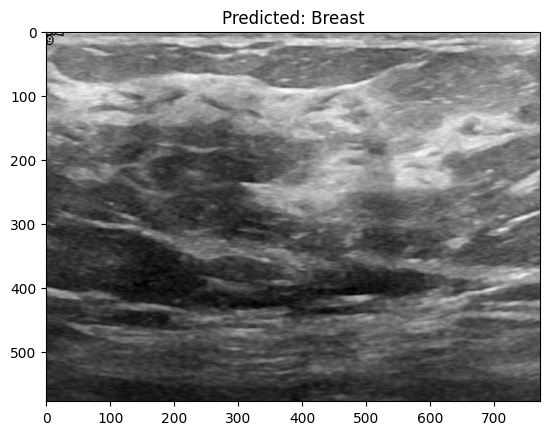

In [37]:
# Test cases breast
random_img= np.random.choice(os.listdir(os.path.join(test_dir, '1')))

label= predict_image(model, os.path.join(test_dir, '1', random_img))

In [186]:
# Save model
model.save('brain_breast_model.h5')